In [1]:
"""Data inspection. For HCP connectomes"""

'Data inspection. For HCP connectomes'

In [9]:
import csv
import importlib
import os

import matplotlib
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)
import toylosses
importlib.reload(toylosses)
import nn
importlib.reload(nn)
import train_utils
importlib.reload(train_utils)

DATA_DIR = '/neuro/'
DATA_TYPE = 'conn'

IMG_SHAPE = (15, 15)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_DATASET_PATH = os.path.join(
    DATA_DIR, 'train_val_datasets/%s_%s_%s.npy' % (
        'train', DATA_TYPE, SHAPE_STR))
VAL_DATASET_PATH = os.path.join(
    DATA_DIR, 'train_val_datasets/%s_%s_%s.npy' % (
        'val', DATA_TYPE, SHAPE_STR))

DATASET_PATH = TRAIN_DATASET_PATH
DATASET = np.load(DATASET_PATH)
# dataset, _ = datasets.get_dataset_connectomes(IMG_SHAPE)

CMAP = 'Spectral'

Using numpy backend


ModuleNotFoundError: No module named 'geomstats.spd_matrices_space'

In [4]:
from ray.tune.analysis import ExperimentAnalysis
analysis = ExperimentAnalysis("/home/nina/ray_results/Train")
print("Best config is", analysis.get_best_logdir(metric="average_neg_elbo", mode='min'))

KeyError: 'average_neg_elbo'

In [3]:
OUTPUT= 'Train_96_batch_size=4,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_15-02-31ix20jroi'
print_criterion(OUTPUT)

NameError: name 'print_criterion' is not defined

In [27]:
METRICS = ['eucl', 'riem', 'log_eucl']
LATENT_DIMS = [4, 10, 40, 60, 100]

def get_output(metric_name, latent_dim):
    main_dir = '/scratch/users/nmiolane/'
    results = 'imoutput_connectomes_%s/latent_dim_%s' % (
        metric_name, latent_dim)
    return os.path.join(main_dir, results)

From: https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

In [25]:
import functools
import train_utils
importlib.reload(train_utils)

DATASET_NAME = 'connectomes'
FRAC_VAL = 0.05
BATCH_SIZE = {
    'mnist': 20,
    'connectomes': 8,
    'connectomes_simu': 8,
    'connectomes_schizophrenia': 16}
IMG_SHAPE = (1, 15, 15)
DATA_DIM = functools.reduce((lambda x, y: x * y), IMG_SHAPE)
SPD_FEATURE = 'matrix'
NN_ARCHITECTURE = {
    'img_shape': IMG_SHAPE,
    'data_dim': DATA_DIM,
    'spd_feature': SPD_FEATURE}

train_dataset, val_dataset = datasets.get_datasets(
    dataset_name=DATASET_NAME,
    frac_val=FRAC_VAL,
    batch_size=BATCH_SIZE[DATASET_NAME],
    img_shape=IMG_SHAPE)

import logging

logging.info(
    'Train tensor: %s' % train_utils.get_logging_shape(train_dataset))
logging.info(
    'Val tensor: %s' % train_utils.get_logging_shape(val_dataset))

print(type(train_dataset))
train_dataset = train_utils.spd_feature_from_matrix(
    train_dataset,
    spd_feature=NN_ARCHITECTURE['spd_feature'])
print(type(train_dataset))
val_dataset = train_utils.spd_feature_from_matrix(
    val_dataset,
    spd_feature=NN_ARCHITECTURE['spd_feature'])

Loading /neuro/train_val_datasets/train_conn_15x15.npy...
Loading /neuro/train_val_datasets/val_conn_15x15.npy...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Show original SPD data

Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)


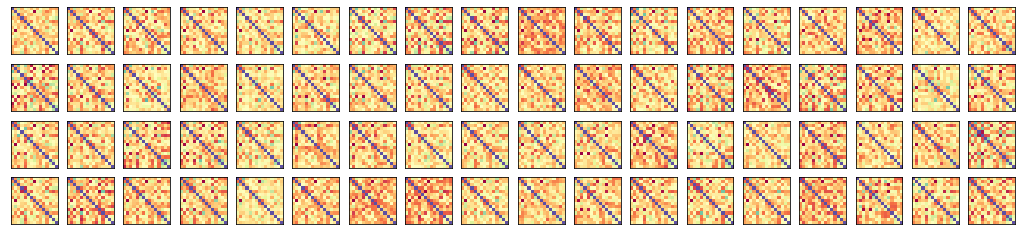

In [4]:
vis.show_data(DATASET_PATH, cmap=CMAP)

In [30]:
def plot_convergence_metric(metric_name, start_epoch_id=0):
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18))

    for i_latent_dim, latent_dim in enumerate(LATENT_DIMS):
        output = get_output(metric_name, latent_dim)
    
        ax = axes[i_latent_dim % 5, int(i_latent_dim / 5)]

        ax = vis.plot_convergence(
            ax, output, algo_name='vae', crit_name='neg_elbo', start_epoch_id=start_epoch_id)
        ax = vis.plot_criterion(
            ax, output, algo_name='vae', crit_name='neg_loglikelihood', start_epoch_id=start_epoch_id,
            mode='val', dashes=True)
        ax.set_title(
            'Convergence of gVAE (%s, L = %s)' % (
                metric_name, latent_dim), 
            fontsize=20)
        ax.set_xlabel('Epochs', fontsize=20)
        ax.set_ylabel('(Unit: nats)', fontsize=20)

        ax.legend(fontsize=14)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
def plot_criterions_vs_latent_dim(ax, metric_name, crit_name):
    last_epoch = 120
    neg_elbos = []
    crits = []
    for latent_dim in LATENT_DIMS:
        output = output = get_output(metric_name, latent_dim)
        val_losses = vis.load_losses(
                output, 'vae', crit_name=crit_name,
                epoch_id=int(last_epoch), mode='val')
        crits.append(val_losses[last_epoch])

    ax.plot(
        LATENT_DIMS, crits, 
        dashes=[2, 2, 2, 2], label = 'VAE: Valid %s (%s)' % (
            crit_name, metric_name),
        color=vis.COLOR_DICT[crit_name])
    
    ax.set_xlabel('Latent dims', fontsize=20)
    ax.set_ylabel('(Unit: nats)', fontsize=20)

    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    ax.legend(fontsize=14)

In [4]:
def get_unexplained_variance(output, dataset_path, variance_name):
    """
    Compute L2 norm between SSD matrices.
    It amounts to the residual variance in the Euclidean space with L2 norm.
    """
    print('Loading %s' % dataset_path)
    img = np.load(dataset_path)
    print('Dataset shape:', img.shape)
    
    recon = vis.get_recon(output, img, algo_name='vae')
    
    if variance_name == 'log_eucl':
        img = train_utils.spd_feature_from_matrix(img, 'log_matrix')
        recon = np.expand_dims(recon, axis=1)
        recon = train_utils.spd_feature_from_matrix(recon, 'log_matrix')
        
    img = np.squeeze(img)
    recon = np.squeeze(recon)
    assert len(recon.shape) == 3
    assert len(img.shape) == 3
    
    ssd = np.sum((img - recon)**2, axis=(1, 2))
    mean_ssd = np.mean(ssd)
    
    mean_img = np.mean(img, axis=0)

    variance = np.mean(np.sum((img - mean_img)**2, axis=(1, 2)))
    
    unexplained_var = mean_ssd / variance
    return unexplained_var

In [5]:
def plot_unexplained_variance_vs_latent_dim(ax, metric_name, dataset_path, variance_name):
    unexplained_vars = []
    for latent_dim in LATENT_DIMS:
        output = get_output(metric_name=metric_name, latent_dim=latent_dim)
        unexplained_var = get_unexplained_variance(
            output, dataset_path, variance_name=variance_name)
        unexplained_vars.append(unexplained_var)
            
    ax.plot(
        LATENT_DIMS, unexplained_vars, 
        dashes=[2, 2, 2, 2], label = 'Unexplained var with metric %s (%s)' % (
            variance_name, metric_name))
    
    ax.set_xlabel('Latent dims', fontsize=20)

    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    ax.legend(fontsize=14)

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_2/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_2/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_2/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_4/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_4/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_4/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_6/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_6/train_vae/epoch_159_checkpoi

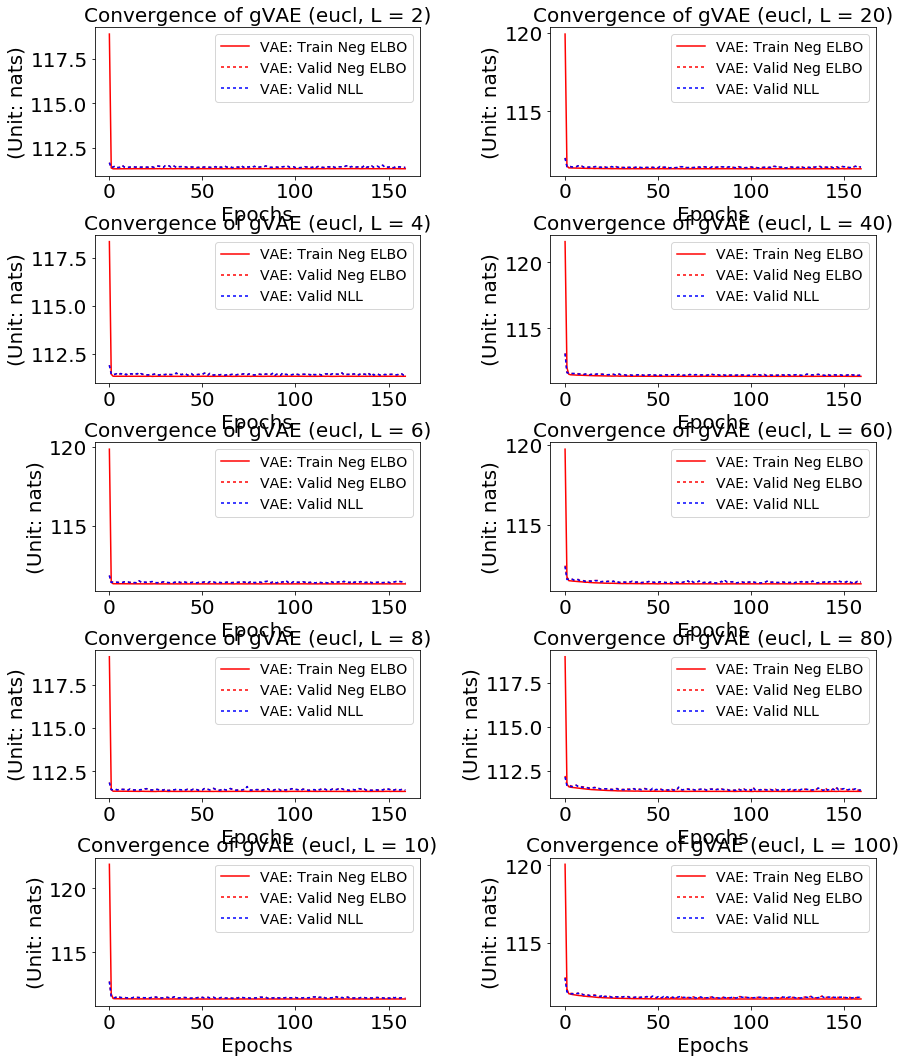

In [47]:
metric_name = 'eucl'
plot_convergence_metric(metric_name=metric_name)

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_2/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_4/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_6/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_8/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_2/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_4/train_vae/epoch_159_checkp

Loading /neuro/train_val_datasets/val_conn_15x15.npy
Dataset shape: (41, 1, 15, 15)
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Loading decoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.


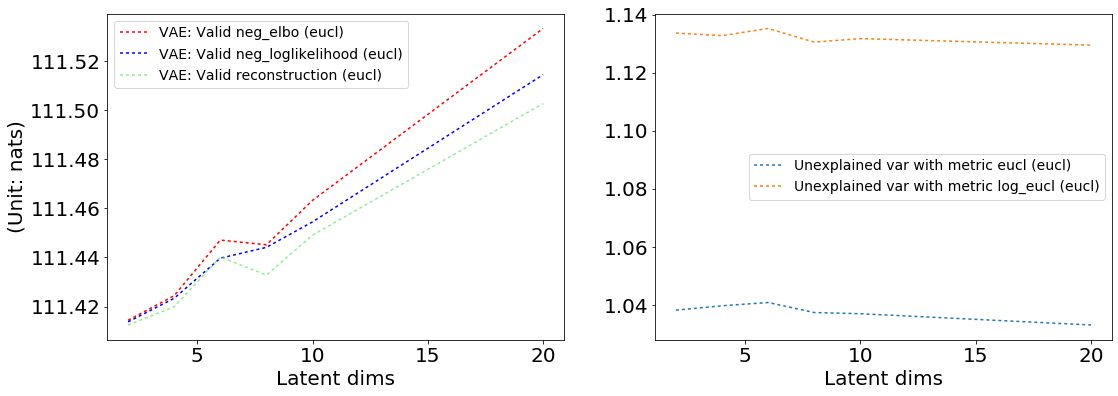

In [17]:
metric_name = 'eucl'

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(121)
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_elbo')
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_loglikelihood')
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='reconstruction')

ax = fig.add_subplot(122)
plot_unexplained_variance_vs_latent_dim(
    ax=ax, metric_name=metric_name, dataset_path=VAL_DATASET_PATH, variance_name='eucl')
plot_unexplained_variance_vs_latent_dim(
    ax=ax, metric_name=metric_name, dataset_path=VAL_DATASET_PATH, variance_name='log_eucl')

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_4/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_4/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_4/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_40/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/laten

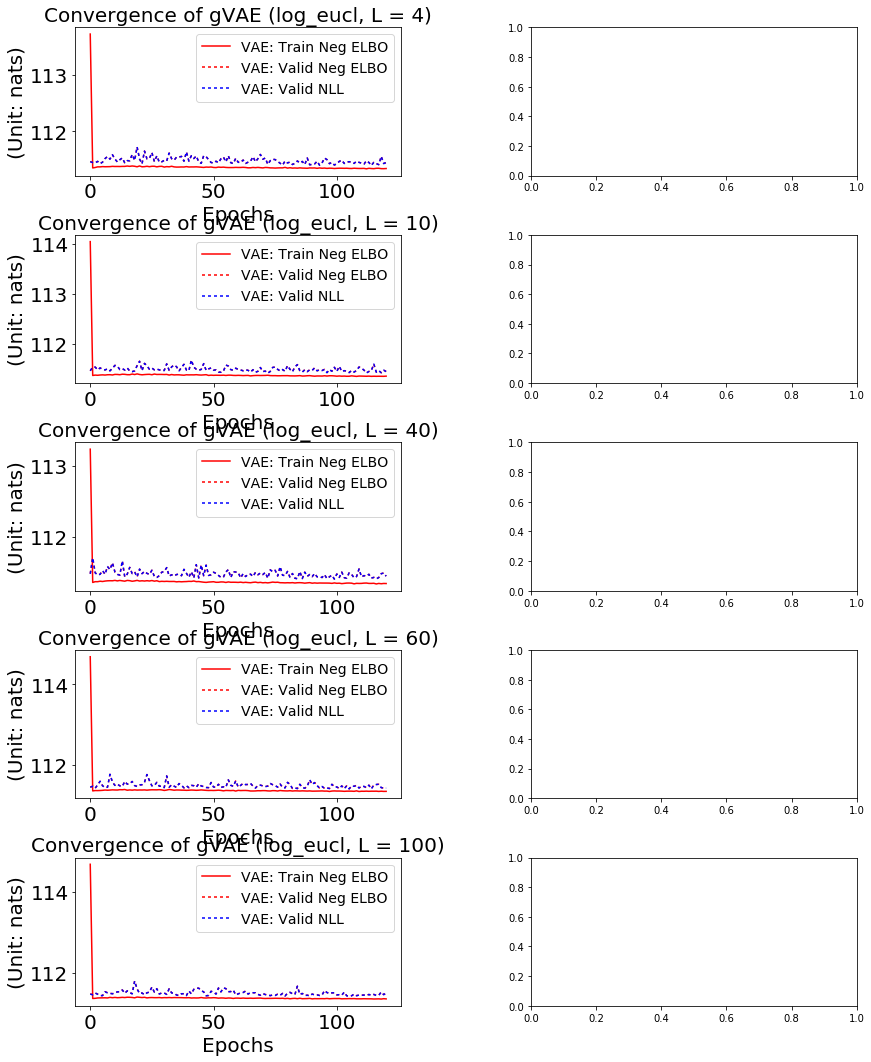

In [28]:
metric_name = 'log_eucl'
plot_convergence_metric(metric_name=metric_name)

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_4/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_40/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_60/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_100/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_4/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_120_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/lat

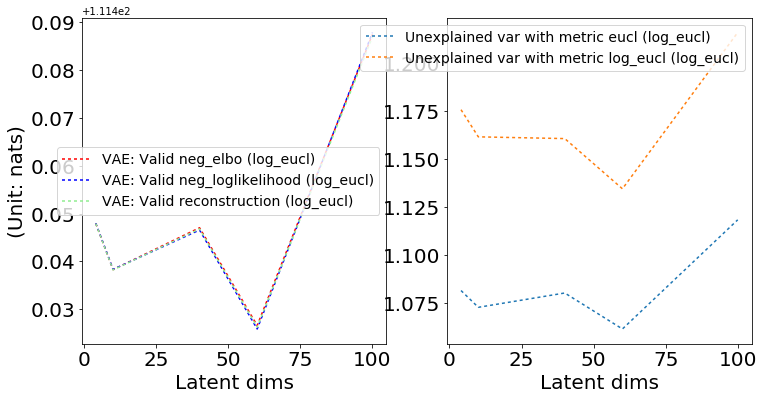

In [33]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_elbo')
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_loglikelihood')
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='reconstruction')

ax = fig.add_subplot(122)
plot_unexplained_variance_vs_latent_dim(
    ax=ax, metric_name=metric_name, dataset_path=VAL_DATASET_PATH, variance_name='eucl')
plot_unexplained_variance_vs_latent_dim(
    ax=ax, metric_name=metric_name, dataset_path=VAL_DATASET_PATH, variance_name='log_eucl')

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_10/train_vae/epoch_87_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_10/train_vae/epoch_87_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_10/train_vae/epoch_87_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_20/train_vae/epoch_35_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_20/train_vae/epoch_35_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_20/train_vae/epoch_35_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_40/train_vae/epoch_30_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_riem/latent_dim_40/train_vae/epoch_30_checkpoi

ValueError: No checkpoints found for epoch 159.

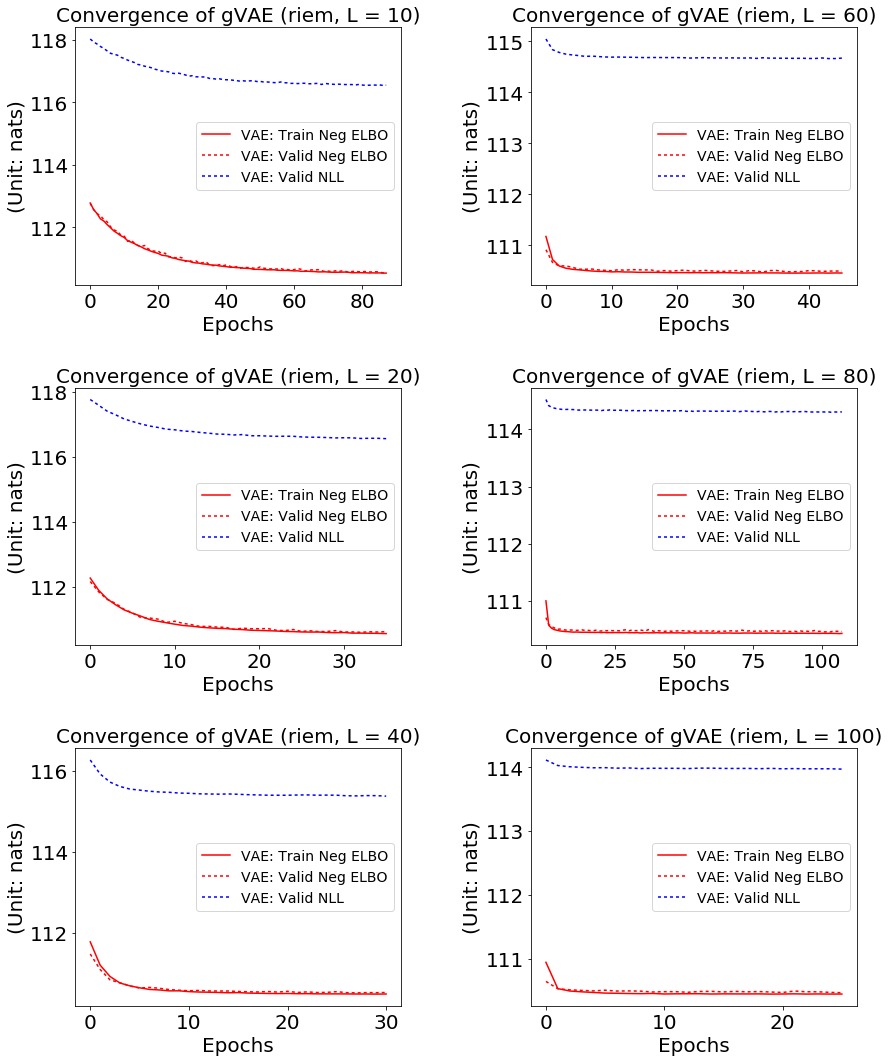

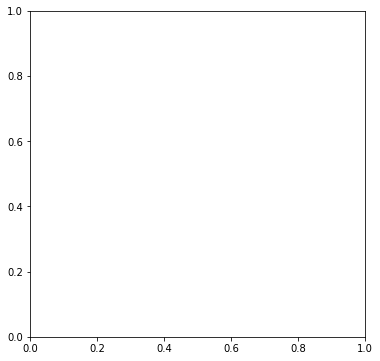

In [76]:
metric_name = 'riem'
plot_convergence_metric(metric_name=metric_name)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_elbo')
plot_criterions_vs_latent_dim(ax=ax, metric_name=metric_name, crit_name='neg_loglikelihood')

# Compare metrics

In [262]:
def plot_metric_comparison():
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(121)
    for metric_name in ['eucl', 'log_eucl']:
        plot_criterions_vs_latent_dim(
            ax=ax, metric_name=metric_name, crit_name='neg_elbo')
        
    ax = fig.add_subplot(122)
    for metric_name in ['eucl', 'log_eucl']:
        plot_criterions_vs_latent_dim(
            ax=ax, metric_name=metric_name, crit_name='neg_loglikelihood')
    
    plt.subplots_adjust(wspace=0.4)

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_40/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_60/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_80/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_100/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_20/train_vae/e

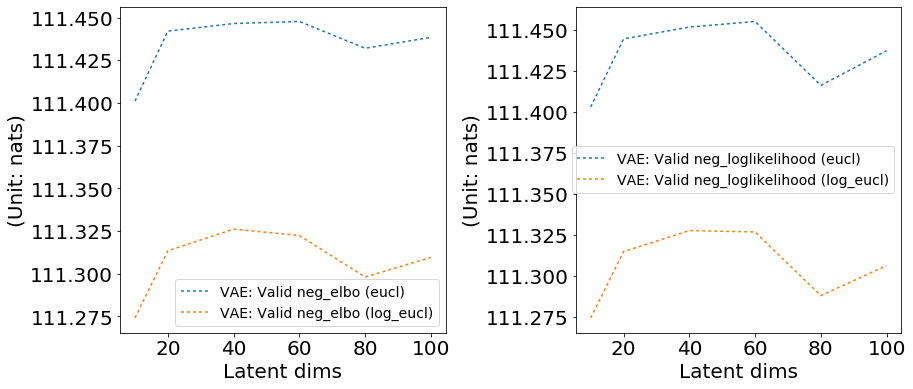

In [263]:
plot_metric_comparison()

Loading /neuro/train_val_datasets/val_conn_15x15.npy
Dataset shape: (41, 1, 15, 15)
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Loading decoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
[[ 1.00201595 -0.22618881]
 [-0.22618881  1.00081539]]
[[ 1.00201631 -0.22614667]
 [-0.22614667  1.00081873]]
[[ 1.00201654 -0.22618148]
 [-0.22618148  1.00081694]]
[[ 1.00201643 -0.22615308]
 [-0.22615308  1.00081897]]
[[ 1.00201595 -0.22615176]
 [-0.22615176  1.00081694]]


AssertionError: 

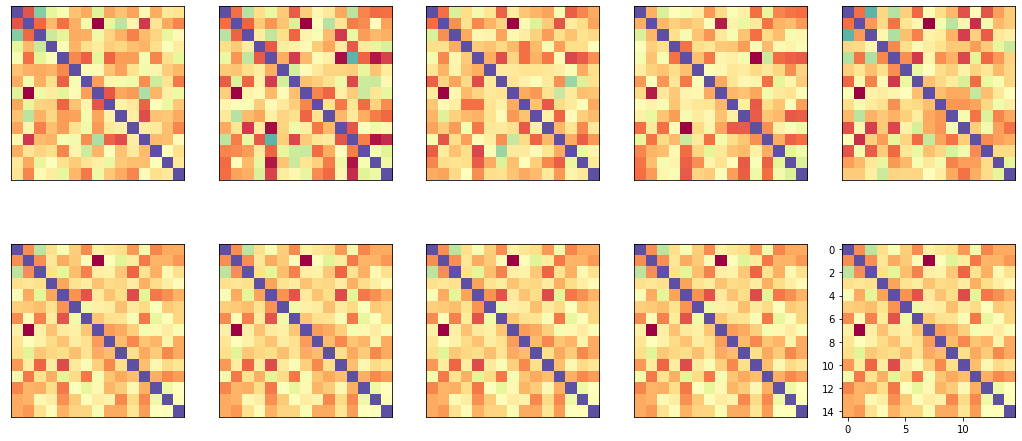

In [7]:
OUTPUT = '/scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/'
vis.show_img_and_recon(OUTPUT, VAL_DATASET_PATH, cmap=CMAP)

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Loading decoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.


/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


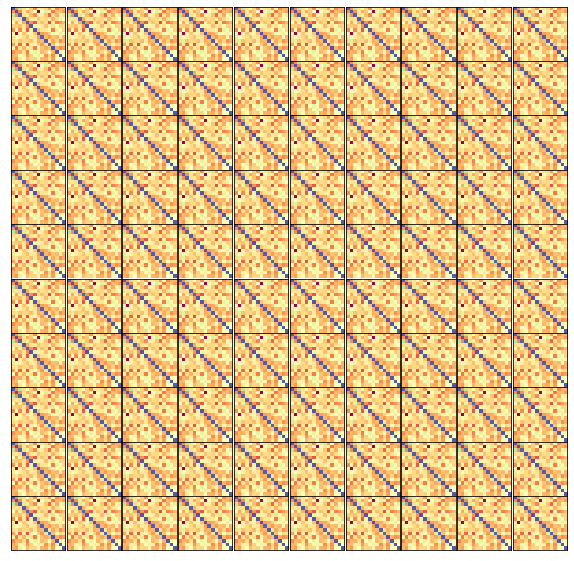

In [12]:
OUTPUT = '/scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_10/'

fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(1, 1, wspace=0.1, hspace=0.1)

for i, algo_name in enumerate(['vae']):
    vis.show_samples_from_prior(
        OUTPUT, fig, outer, i, algo_name=algo_name, cmap=CMAP)
fig.show()

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_20/train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_40/train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_40/train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/laten

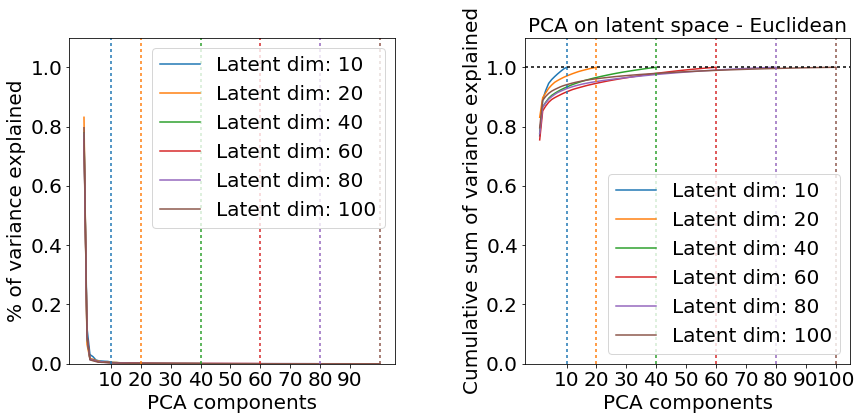

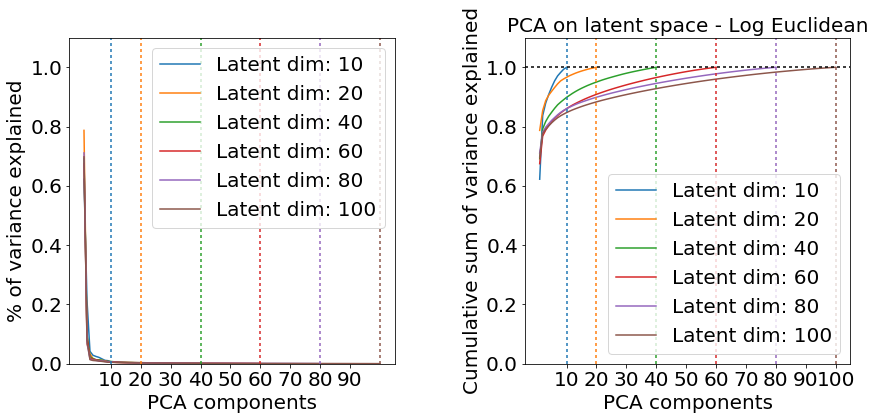

In [261]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for latent_dim in LATENT_DIMS:
    output = '/scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_%d' % latent_dim

    ax = vis.plot_variance_explained(output, DATASET_PATH, axes=axes)

    
#ax.set_title('Variance explained', fontsize=20)
#
#ax.set_ylabel('(Unit: nats)', fontsize=20)
 
axes[0].set_xlabel('PCA components', fontsize=20)
axes[0].set_ylabel('% of variance explained', fontsize=20)
axes[0].legend(fontsize=20)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].locator_params(axis='y', nbins=6)
axes[0].xaxis.set_ticks(np.arange(10, 100, 10))


axes[1].set_xlabel('PCA components', fontsize=20)
axes[1].set_ylabel('Cumulative sum of variance explained', fontsize=20)
axes[1].legend(fontsize=20, loc='lower right')
axes[1].locator_params(axis='y', nbins=6)
axes[1].xaxis.set_ticks(np.arange(10, 110, 10))
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

for i_dim, latent_dim in enumerate(all_latent_dims):
    axes[0].axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
    axes[1].axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
axes[1].axhline(y=1., color='black', dashes=[2, 2])
axes[1].set_title('PCA on latent space - Euclidean', fontsize=20)

plt.subplots_adjust(wspace=0.4)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for latent_dim in LATENT_DIMS:
    output = '/scratch/users/nmiolane/imoutput_connectomes_log_eucl/latent_dim_%d' % latent_dim

    ax = vis.plot_variance_explained(output, DATASET_PATH, axes=axes)

    
#ax.set_title('Variance explained', fontsize=20)
#
#ax.set_ylabel('(Unit: nats)', fontsize=20)
 
axes[0].set_xlabel('PCA components', fontsize=20)
axes[0].set_ylabel('% of variance explained', fontsize=20)
axes[0].legend(fontsize=20)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].locator_params(axis='y', nbins=6)
axes[0].xaxis.set_ticks(np.arange(10, 100, 10))


axes[1].set_xlabel('PCA components', fontsize=20)
axes[1].set_ylabel('Cumulative sum of variance explained', fontsize=20)
axes[1].legend(fontsize=20, loc='lower right')
axes[1].locator_params(axis='y', nbins=6)
axes[1].xaxis.set_ticks(np.arange(10, 110, 10))
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

for i_dim, latent_dim in enumerate(LATENT_DIMS):
    axes[0].axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
    axes[1].axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
axes[1].axhline(y=1., color='black', dashes=[2, 2])
axes[1].set_title('PCA on latent space - Log Euclidean', fontsize=20)
plt.subplots_adjust(wspace=0.4)

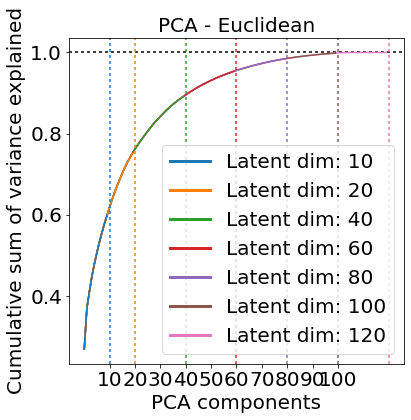

<Figure size 432x288 with 0 Axes>

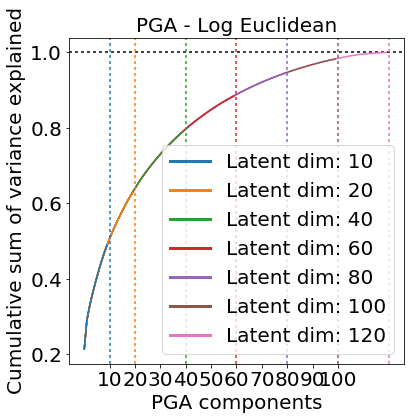

In [358]:
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
from geomstats.spd_matrices_space import SPDMatricesSpace

dataset = np.load(TRAIN_DATASET_PATH)

dataset_vector = train_utils.spd_feature_from_matrix(
    dataset, spd_feature='vector')
dataset_vector = dataset_vector[:, 0, :]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.set_xlabel('PCA components', fontsize=20)
ax.set_ylabel('Cumulative sum of variance explained', fontsize=20)
#ax.legend(fontsize=20, loc='lower right')
ax.locator_params(axis='y', nbins=6)
ax.xaxis.set_ticks(np.arange(10, 110, 10))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.axhline(y=1., color='black', dashes=[2, 2])
ax.set_title('PCA - Euclidean', fontsize=20)

all_latent_dims = [10, 20, 40, 60, 80, 100, 120]
colors = []
labels = []
for i_dim, latent_dim in enumerate(all_latent_dims):
    colors.append('C%d' % i_dim)
    labels.append('Latent dim: %d' % latent_dim)

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
plt.legend(lines, labels, fontsize=20, loc='lower right')


for i_dim, latent_dim in reversed(list(enumerate(all_latent_dims))):
    ax.axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
    
    pca = PCA(n_components=latent_dim)
    pca.fit(dataset_vector)

    cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(cum_explained_var, color='C%d' % i_dim)


plt.figure()
dataset_log_vector = train_utils.spd_feature_from_matrix(
    dataset, spd_feature='log_vector')
dataset_log_vector = dataset_log_vector[:, 0, :]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.set_xlabel('PGA components', fontsize=20)
ax.set_ylabel('Cumulative sum of variance explained', fontsize=20)
#ax.legend(fontsize=20, loc='lower right')
ax.locator_params(axis='y', nbins=6)
ax.xaxis.set_ticks(np.arange(10, 110, 10))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.axhline(y=1., color='black', dashes=[2, 2])
ax.set_title('PGA - Log Euclidean', fontsize=20)

all_latent_dims = [10, 20, 40, 60, 80, 100, 120]
colors = []
labels = []
for i_dim, latent_dim in enumerate(all_latent_dims):
    colors.append('C%d' % i_dim)
    labels.append('Latent dim: %d' % latent_dim)

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
plt.legend(lines, labels, fontsize=20, loc='lower right')

for i_dim, latent_dim in reversed(list(enumerate(all_latent_dims))):
    ax.axvline(x=latent_dim, color='C%d' % i_dim, dashes=[2, 2])
    
    pca = PCA(n_components=latent_dim)
    pca.fit(dataset_log_vector)

    cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(cum_explained_var, color='C%d' % i_dim)

In [8]:
def get_hcp(labels_path):
    labels = {}
    labels['Gender'] = []
    labels['Age'] = []
    with open(labels_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for i_row, row in enumerate(reader):
            if i_row == 0:
                continue
            labels['Gender'].append(row[1])
            labels['Age'].append(row[2])

    return labels

In [9]:
labels = get_hcp('/neuro/train_val_datasets/hcp_labels.csv')

In [10]:
OUTPUT = '/scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10/'

COLORS_GENDER = {'F': 'green', 'M': 'blue'}
COLORS_AGE = {'22-25': 'yellow', '26-30': 'orange', '31-35': 'red', '36+':'purple'}

COLORS = {'Gender': COLORS_GENDER, 'Age': COLORS_AGE}

def plot_connectomes(ax, output=OUTPUT, dataset_path=DATASET_PATH, 
              labels_path='/neuro/train_val_datasets/hcp_labels.csv', 
              n_pcs=2, label_name='Gender'):
    labels = get_hcp(labels_path)
    colored_labels = labels[label_name]
    
    mus = analyze.latent_projection(output, dataset_path)

    _, projected_mus = analyze.pca_projection(mus, n_pcs)
    colors = COLORS[label_name]
    for mu, colored_label in zip(projected_mus, colored_labels):
        if n_pcs == 2:
            im = ax.scatter(mu[0], mu[1], c=colors[colored_label], s=8)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=colors[colored_label])
    return im, ax

Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/imoutput_connectomes_eucl/latent_dim_10//train_vae/epoch_159_checkpoint.pth.
Loading encoder from network of architecture: fc...


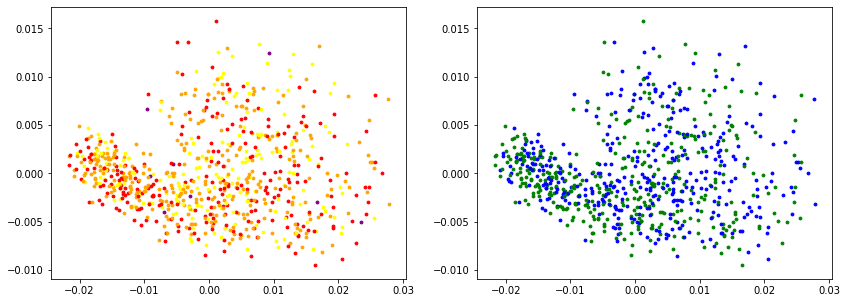

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax = axes[0]
im, ax = plot_connectomes(ax, label_name='Age')

ax = axes[1]
im, ax = plot_connectomes(ax, label_name='Gender')